### Test the model security by Adversarial Attack using FGD method

In [1]:
# ! pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.7.0/MindSpore/cpu/x86_64/mindspore-1.7.0-cp39-cp39-win_amd64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
import os 
import math
import pandas as pd 
import numpy as np
from skimage import io, transform 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_datasets as tfds
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import losses
import tensorflow_model_optimization as tfmot

from tcn import TCN

In [3]:
IMAGE_SIZE = (128,48)
DATA_BS = 10
DATA_N = 10
LR = 0.005
EPOCHS = 20
BS = 48

In [4]:
(ds_train, ds_test), info = tfds.load('mnist', split=['train', 'test'], with_info=True)
train_gen = tfds.as_numpy(ds_train)
test_gen = tfds.as_numpy(ds_test)

Load dataset info from ~\tensorflow_datasets\mnist\3.0.1
Field info.citation from disk and from code do not match. Keeping the one from code.
Field info.splits from disk and from code do not match. Keeping the one from code.
Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
Field info.module_name from disk and from code do not match. Keeping the one from code.
Reusing dataset mnist (~\tensorflow_datasets\mnist\3.0.1)
Constructing tf.data.Dataset mnist for split ['train', 'test'], from ~\tensorflow_datasets\mnist\3.0.1


In [5]:
class MNISTDataset(object):

    def __init__(self, n_digits=8, image_size=(156, 32)):
        self.n_digits = n_digits
        self.image_size = image_size

    def gen_data(self, gen):
        images, labels = [], []
        for x in gen:
            images.append(x['image'])
            labels.append(x['label'])
        images, labels = np.squeeze(np.array(images)), np.squeeze(np.array(labels)); print(images.shape,labels.shape,labels)
        return images, labels

    def gen_patch(self, img, ann, c=np.inf):
        size = img.shape[0]
        indexes = np.arange(size)
        np.random.shuffle(indexes)
        
        c_prime = divmod(size, self.n_digits)[0]*self.n_digits
        if c_prime < c:
            size = c_prime
        else:
            size = divmod(c, self.n_digits)[0]*self.n_digits

        sample_index = indexes[:size]
        sticker_index = sample_index.reshape((-1, self.n_digits)).T
        sticker_images = np.transpose(np.hstack([np.transpose(img[inds], (0, 2, 1)) for inds in sticker_index]), (0, 2, 1))
        sfl_label =  ann[sample_index, ...]
        sticker_labels = sfl_label.reshape((-1, self.n_digits))
        return sticker_images, sticker_labels

    def generate(self, data_generator, n_sample):
        init_image, init_label = self.gen_data(data_generator)
        c = n_sample
        dt_images, dt_labels = self.gen_patch(init_image, init_label, c)
        while c > self.n_digits:
            c = n_sample - dt_images.shape[0]
            p_images, p_labels = self.gen_patch(init_image, init_label, c)
            dt_images, dt_labels = np.vstack((dt_images, p_images)), np.vstack((dt_labels, p_labels))

        ret_tensor = tf.convert_to_tensor(np.swapaxes(dt_images, 1, 2), dtype=tf.float32);print(dt_images.shape,dt_labels.shape)
        ind_tensor = tf.convert_to_tensor(dt_labels, dtype=tf.int32)
        dataset = tf.data.Dataset.from_tensor_slices((ret_tensor, ind_tensor))
        return dataset
    

In [6]:
mnist = MNISTDataset()


In [7]:
train_dataset = mnist.generate(train_gen, n_sample=10000)
test_dataset = mnist.generate(test_gen, n_sample=2000)

(60000, 28, 28) (60000,) [4 1 0 ... 6 1 5]
(9993, 28, 224) (9993, 8)
(10000, 28, 28) (10000,) [2 0 4 ... 8 0 5]
(1993, 28, 224) (1993, 8)


(224, 28)
[2 6 1 7 6 0 9 1]


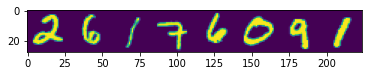

In [8]:
for i in test_dataset.take(1):
    img, label = i
print(img.shape)
print(label.numpy())
plt.imshow(img.numpy().T)
IMAGE_SIZE = img.shape

In [9]:
train_loader = train_dataset.shuffle(buffer_size=1000).batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_loader = test_dataset.batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
class mAP(tf.keras.metrics.Metric):
    def __init__(self, name='mAP', alpha=0.9, **kwargs):
        super(mAP, self).__init__(name=name, **kwargs)
        self.map = self.add_weight(name='map', initializer='zeros')
        self.alpha = alpha

    def update_state(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        alpha = tf.constant(self.alpha, dtype=tf.float32)
        alpha_prime = tf.constant(1-self.alpha, dtype=tf.float32)

        res_arr = tf.map_fn(lambda i: tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(y_true[i, ...], y_pred[i, ...])), elems=tf.range(y_pred.shape[0]), dtype=tf.float32)
        tensor_without_nans = tf.where(tf.math.is_nan(res_arr), tf.zeros_like(res_arr), res_arr)
        cur_val = tf.math.reduce_mean(tensor_without_nans, axis=-1)
        weighted_avg = tf.math.add(tf.multiply(alpha, self.map), tf.multiply(alpha_prime, cur_val))
        self.map.assign(weighted_avg)

    def result(self):
        return self.map


In [11]:
class mDP(tf.keras.metrics.Metric):
    def __init__(self, name='mDP', n_classes=10, alpha=0.9, **kwargs):
        super(mDP, self).__init__(name=name, **kwargs)
        self.n = n_classes
        self.alpha = alpha
        self.mdp = self.add_weight(name='mdp', initializer='zeros')

    def update_state(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        alpha = tf.constant(self.alpha, dtype=tf.float32)
        alpha_prime = tf.constant(1-self.alpha, dtype=tf.float32)

        def func(i):
            mask = tf.equal(y_true, tf.constant(i))
            ilabels = tf.reshape(tf.boolean_mask(y_true,mask), shape=(-1))
            ipreds = tf.reshape(tf.boolean_mask(y_pred,mask), shape=(-1, self.n))
            return tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(ilabels, ipreds))

        res_arr = tf.map_fn(lambda i: func(i), elems=tf.range(self.n), dtype=tf.float32)
        tensor_without_nans = tf.where(tf.math.is_nan(res_arr), tf.zeros_like(res_arr), res_arr)
        cur_val = tf.math.reduce_mean(tensor_without_nans, axis=-1)
        weighted_avg = tf.math.add(tf.multiply(alpha, self.mdp), tf.multiply(alpha_prime, cur_val))
        self.mdp.assign(weighted_avg)

    def result(self):
        return self.mdp

In [12]:
class RecNet(tf.keras.Model):
	def __init__(self, bs=16, input_size=(128, 48), n_classes=10, h_cell=64, latent_size=32, max_obj=15, linear_k=3, rho=0.05):
		super().__init__()
		self.rho = rho
		self.bs = bs
		self.input_size = input_size
		self.n_classes = n_classes  # LSTM module projection size
		self.h_cell = h_cell  # LSTM hidden size
		self.latent_size = latent_size
		self.max_obj = max_obj
		self.linear_k = linear_k
		self.model = self.build_model(
			self.input_size, self.h_cell, self.latent_size, self.n_classes, self.max_obj, self.linear_k)

		self.scce = losses.SparseCategoricalCrossentropy(from_logits=False,)

		self.loss_metric = tf.keras.metrics.Mean(name="loss")
		self.acc_metric = tf.keras.metrics.Mean(name="accuracy")
		self.mAP = mAP()
		self.mDP = mDP(n_classes=self.n_classes)
		self.acc_mat = tf.keras.metrics.Accuracy()

	def build_model(self, input_shape=(128, 48), h_cell=32, latent_size=32, n_classes=10, n_obj=10, linear_k=3):
		x_input = layers.Input(shape=input_shape)
		forward_layer = layers.LSTM(h_cell//2, return_sequences=True)
		x = layers.Bidirectional(forward_layer, input_shape=self.input_size)(x_input)
		x = layers.LSTM(latent_size, activation='tanh',
						return_sequences=True, go_backwards=True)(x)
		x = layers.Conv1D(n_classes, linear_k, activation='tanh')(x)
		x = layers.Permute((2, 1))(x)
		x = layers.Conv1D(n_obj, 1, activation='tanh')(x)
		x = layers.Permute((2, 1))(x)
		x_output = layers.Activation('softmax')(x)

		model = tf.keras.Model(inputs=x_input, outputs=x_output)
		return model

	@property
	def metrics(self):
		return [self.loss_metric, self.acc_mat]

	def calculate_loss(self, target, pred):
		target = tf.reshape(target, shape=(-1))
		pred = tf.reshape(pred, shape=(-1, self.n_classes))
		loss = self.scce(target, pred)

		y_hat = tf.argmax(pred, axis=-1)
		acc = self.acc_mat(y_hat, target)
		return loss, acc

	def call(self, x):
		full_out = self.model(x)
		return full_out

	def train_step(self, batch_data):
		x, target = batch_data
		e_ws = []
		with tf.GradientTape() as tape:
			pred = self(x, training=True)
			# print(pred.shape, pred)
			loss, acc = self.calculate_loss(target, pred)

		trainable_params = self.trainable_variables
		gradients = tape.gradient(loss, trainable_params)
		grad_norm = self._grad_norm(gradients)
		scale = self.rho / (grad_norm + 1e-12)

		for (grad, param) in zip(gradients, trainable_params):
			e_w = grad*scale 
			param.assign_add(e_w)
			e_ws.append(e_w)

		with tf.GradientTape() as tape:
			pred = self(x, training=True)
			loss, acc = self.calculate_loss(target, pred)

		sam_gradient = tape.gradient(loss, trainable_params)
		for (param, e_w) in zip(trainable_params, e_ws):
			param.assign_sub(e_w)

		self.optimizer.apply_gradients(zip(sam_gradient, trainable_params))
		self.loss_metric.update_state(loss)
		self.acc_metric.update_state(acc)
		self.mAP.update_state(target, pred)
		self.mDP.update_state(target, pred)
		return {
			"loss": self.loss_metric.result(),
			"accuracy": self.acc_mat.result(),
			"mAP": self.mAP.result(),
			"mDP": self.mDP.result()
		}

	def test_step(self, batch_data):
		x, target = batch_data

		pred = self(x, training=False)
		loss, acc = self.calculate_loss(target, pred)

		self.loss_metric.update_state(loss)
		self.acc_metric.update_state(acc)
		self.mAP.update_state(target, pred)
		self.mDP.update_state(target, pred)
		return {
			"loss": self.loss_metric.result(),
			"accuracy": self.acc_mat.result(),
			"mAP": self.mAP.result(),
			"mDP": self.mDP.result()
		}

	def _grad_norm(self, gradients):
		norm = tf.norm(
			tf.stack([
				tf.norm(grad) for grad in gradients if grad is not None
			])
		)
		return norm


In [13]:
recNet = RecNet(input_size=IMAGE_SIZE,
                bs=BS,
                n_classes=10,
                h_cell=32,
                max_obj=10,
                linear_k=3)

In [14]:
recNet.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 28)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 224, 32)          5760      
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 224, 32)           8320      
                                                                 
 conv1d (Conv1D)             (None, 222, 10)           970       
                                                                 
 permute (Permute)           (None, 10, 222)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 10)            2230      
                                                             

In [15]:
def lr_time_based_decay(epoch, lr):
    decay = 0.001
    return lr * 1 / (1 + decay * epoch)

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return LR * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return LR * math.exp(-k*epoch)

decay_steps = 1000
# lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
#     LR, decay_steps)

lr_decaying_callback = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)

In [16]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=0,
                            patience=5,
                            restore_best_weights=True
                        )

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
)

In [19]:
# model = RecNet(bs=BS)
model = RecNet(input_size=IMAGE_SIZE,
                bs=BS,
                n_classes=10,
                h_cell=32,
                max_obj=8,
                linear_k=3)
model.compile(optimizer, loss='categorical_crossentropy', run_eagerly=True)

In [20]:
model.fit(
    train_loader,
    epochs=10,
    validation_data=valid_loader,
    callbacks=[earlystopping_callback,
               lr_decaying_callback]
)



Epoch 00001: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/10
208/208 [==============================] - 67s 313ms/step - loss: 1.1870 - accuracy: 0.7912 - mAP: 0.7456 - mDP: 0.7429 - val_loss: 0.9285 - val_accuracy: 0.9273 - val_mAP: 0.9269 - val_mDP: 0.9268 - lr: 0.0050

Epoch 00002: LearningRateScheduler setting learning rate to 0.005.
Epoch 2/10
208/208 [==============================] - 65s 314ms/step - loss: 0.9175 - accuracy: 0.9366 - mAP: 0.9326 - mDP: 0.9320 - val_loss: 0.8857 - val_accuracy: 0.9470 - val_mAP: 0.9444 - val_mDP: 0.9441 - lr: 0.0050

Epoch 00003: LearningRateScheduler setting learning rate to 0.005.
Epoch 3/10
208/208 [==============================] - 65s 313ms/step - loss: 0.8938 - accuracy: 0.9480 - mAP: 0.9452 - mDP: 0.9447 - val_loss: 0.8757 - val_accuracy: 0.9524 - val_mAP: 0.9536 - val_mDP: 0.9539 - lr: 0.0050

Epoch 00004: LearningRateScheduler setting learning rate to 0.005.
Epoch 4/10
208/208 [==============================] - 66s 317m

In [21]:
from copy import deepcopy

pretrained_model = model #deepcopy(model)

def create_adversarial_pattern(input_image, input_label, eps=0.3):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss, _ = pretrained_model.calculate_loss(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  adversarial_sample = input_image + eps*signed_grad
  return adversarial_sample

In [22]:
adv_dataset = mnist.generate(test_gen, n_sample=1000)
adv_images, adv_labels = [], []
for i in adv_dataset.take(100):
    image, labels = i
    adv_images.append(create_adversarial_pattern(tf.expand_dims(image, axis=0), labels).numpy())
    adv_labels.append(labels.numpy())
    # print(image.shape, labels.shape)

adv_images, adv_labels = np.squeeze(np.array(adv_images)), np.array(adv_labels)

(10000, 28, 28) (10000,) [2 0 4 ... 8 0 5]
(993, 28, 224) (993, 8)


In [23]:
adv_images.shape

(100, 224, 28)

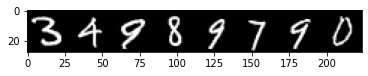

In [24]:
plt.imshow(adv_images[0, ...].T, cmap='gray')

In [25]:
tf_adv_samples = tf.convert_to_tensor(adv_images)
pred_labels = model(tf_adv_samples)

In [26]:
pred_classes = tf.argmax(pred_labels, axis=-1)
pred_classes.shape

TensorShape([100, 8])

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(np.reshape(adv_labels, (-1)), np.reshape(pred_classes.numpy(), (-1)))

0.88625

with epsilone = 0.1

In [30]:
adv_dataset = mnist.generate(test_gen, n_sample=1000)
adv_images, adv_labels = [], []
for i in adv_dataset.take(100):
    image, labels = i
    adv_images.append(create_adversarial_pattern(tf.expand_dims(image, axis=0), labels, eps=0.1).numpy())
    adv_labels.append(labels.numpy())
    # print(image.shape, labels.shape)

adv_images, adv_labels = np.squeeze(np.array(adv_images)), np.array(adv_labels)

(10000, 28, 28) (10000,) [2 0 4 ... 8 0 5]
(993, 28, 224) (993, 8)


In [31]:
tf_adv_samples = tf.convert_to_tensor(adv_images)
pred_labels = model(tf_adv_samples)
pred_classes = tf.argmax(pred_labels, axis=-1)
accuracy_score(np.reshape(adv_labels, (-1)), np.reshape(pred_classes.numpy(), (-1)))

0.9575

In [34]:
adv_loader = adv_dataset.batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
pred_labels = model.evaluate(adv_loader)
pred_classes = tf.argmax(pred_labels, axis=-1)
accuracy_score(np.reshape(adv_labels, (-1)), np.reshape(pred_classes.numpy(), (-1)))

20/20 [==============================] - 5s 235ms/step - loss: 0.8551 - accuracy: 0.9655 - mAP: 0.9655 - mDP: 0.9653


In [1]:
0.9655 - 0.88652

0.07898000000000005